In [2]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import Rung as rg

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -2
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

def min_MSE_finder(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)


def min_MSE_finder1(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]
    refined_link = []
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_pred, y_test)
        if mse < result[-1]:
            result.append(mean_squared_error(y_pred, y_test))
            refined_link.append(link[z])
    return(result,np.array(refined_link))

In [31]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2001, 12, 1, 0, 0) }

ET_gamma = np.load("ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [7]:
n_components_sst = 76

In [36]:
len(count[:ts.shape[0]])

300

In [33]:
ts.shape[0]

300

In [14]:
l = []
df_cluster_sst = []


sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)
for ijz in range(3):
    #scale = StandardScaler()
    #scaled_data = scale.fit_transform(data_sst)

    pca = PCA(n_components=n_components_sst)
    pca_model = pca.fit(data_sst)
    df_cluster_sst.append(pca_model.transform(data_sst))


In [32]:
l = []
df_cluster_sst = []


sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)
for ijz in range(3):
    V, U, S, ts, eig, explained, max_comps = rg.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
    df_cluster_sst.append(ts)

In [29]:
r = []
for i in range(n_components_sst):
    r.append(np.linalg.norm(df_cluster_sst[0][:,i] - df_cluster_sst[2][:,i]))

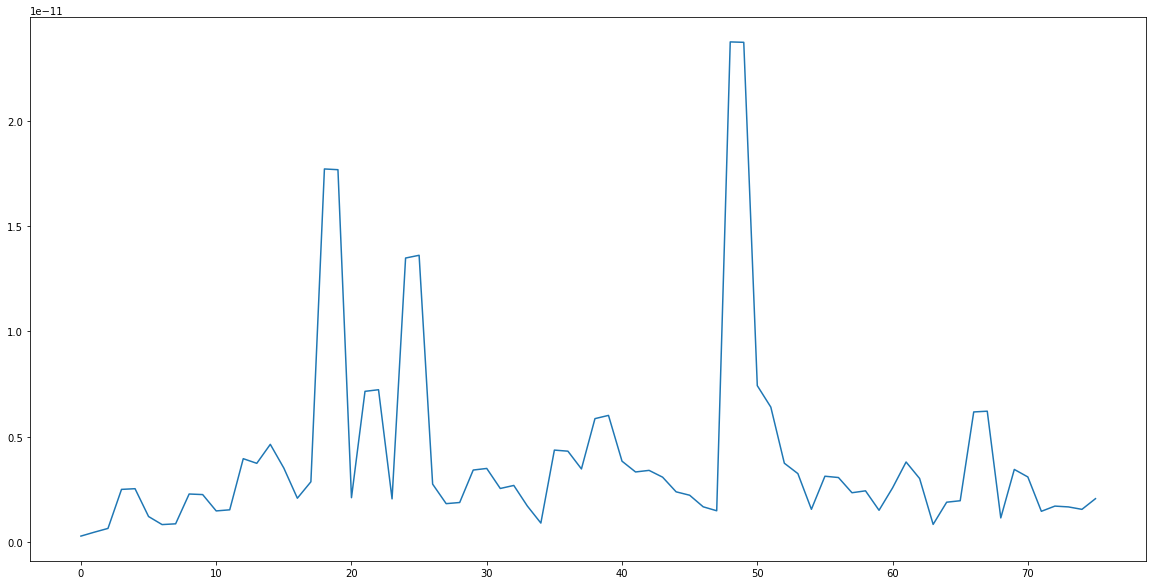

In [30]:
plt.plot(r)

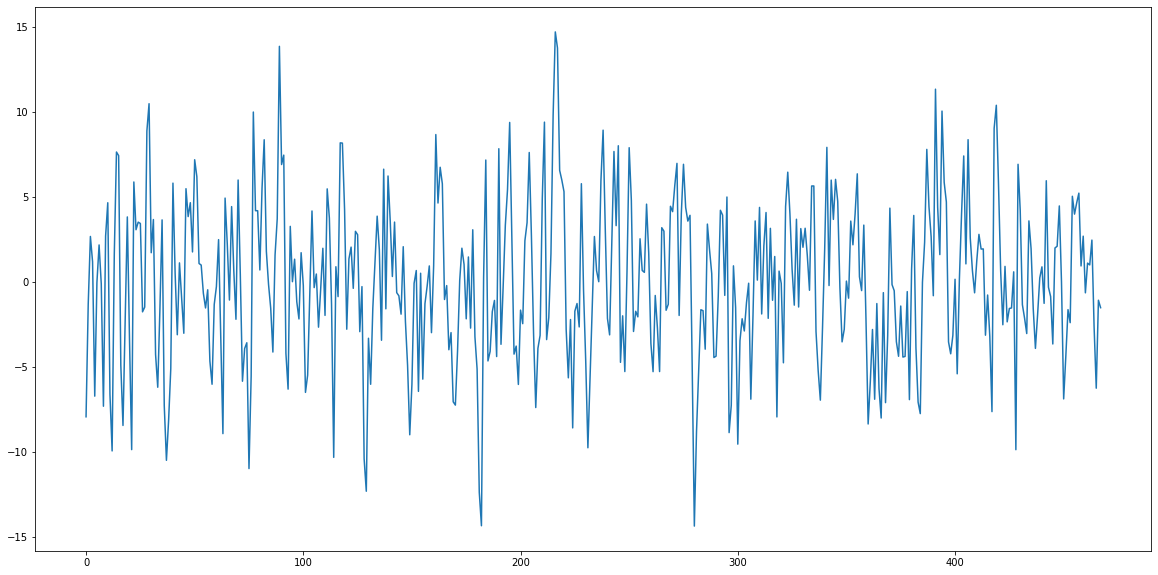

In [44]:
plt.plot(df_cluster_sst[2][:,70])